```shell
docker run --rm -ti \
           -p 8888:8888 \
           -p 8787:8787 \
           -p 4000:4000 \
           -v ${PWD}:/home/jovyan/work \
           -v /media/dani/DataStore/data/:/home/jovyan/data \
           darribas/gds_dev:6.1
```

# Chip making

This document shows how we flexibly generate a grid of pixel patches (or chips) and select those that fully fall within a given signature class.

In [1]:
import os, time
import pandas
import geopandas
import tools
import xarray, rioxarray
from geopandas_view import view
from shapely.geometry import box
import dask.dataframe as ddf

from joblib import Parallel, delayed
from dask.distributed import LocalCluster, Client
import dask
import dask.distributed

import dask_geopandas
print(dask_geopandas.__version__)

tmp_dir = '/home/jovyan'
out_f_xys = f'{tmp_dir}/chip_xys_liv'
grid_dir = f'{tmp_dir}/grid'
joined_dir = f'{tmp_dir}/joined'

v0.1.0a4+24.g393dcb5


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45027 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 67.10 GB


## Read data in

- Signatures (simplified)

In [3]:
sigs = geopandas.read_file(
    '/home/jovyan/data/spatial_signatures/signatures_combined_levels_simplified.gpkg'
)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


- Mosaic

In [4]:
r = rioxarray.open_rasterio(
    '/home/jovyan/data/ghs_composite_s2/GHS-composite-S2.vrt',
    chunks={'x': 1024, 'y': 1024}
)

Liverpool for prototyping:

In [5]:
#bb = box(331825, 385032, 340167, 395756)
bb = box(321566, 468106, 365379, 437198)
liv = r.sel(
    band=[1, 2, 3]
).rio.clip_box(
    *bb.bounds
).compute()

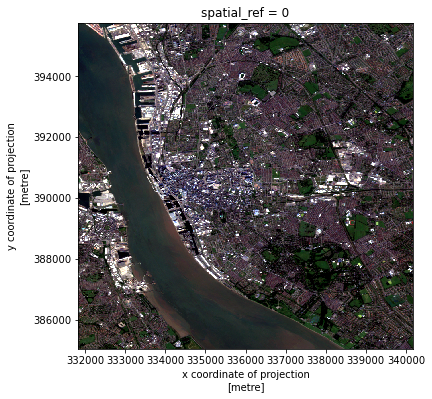

In [5]:
def minmax(
    a, 
    bottom=0, 
    top=255, 
    min_cut=2.5, 
    max_cut=98.5
):
    from numpy import percentile
    vals = a.to_series().values
    min_bin = percentile(vals, min_cut)
    max_bin = percentile(vals, max_cut)
    a = xarray.where(a > max_bin, max_bin, a)
    a = xarray.where(a < min_bin, min_bin, a)
    a_std = (a - a.min()) / (a.max() - a.min())
    a_scaled = a_std * (top - bottom) + bottom
    return a_scaled.astype(int)

liv.groupby(
    "band"
).map(
    minmax
).plot.imshow(figsize=(6, 6));

## Build the grid

The goal here is to have a flexible and performant method to generate a uniform grid of polygons (`GeoDataFrame`) that matches the layout of pixels in the mosaic.

### Small datasets

For small datasets, we can all pack it into a single shot:

In [6]:
%%time
liv_grid = tools.build_grid(
    liv.coords['x'], liv.coords['y'], 6, crs=liv.rio.crs
)

CPU times: user 4.34 s, sys: 60.9 ms, total: 4.4 s
Wall time: 1.51 s


### Larger-than-RAM datasets

Datasets that do not fit in memory can be run through `dask-geopandas`, but it is worth splitting the job across different steps.

- [X] Turn coords into grid XYs as a `dask.DataFrame` w/ `Point` objects --> `chip_pts`
- [X] Turn `chip_pts` into pixel squares --> `grid`
- [ ] Join `sigs` to `grid` to transfer label and discard mixed-signature chips --> `sig_chips`

To select the number of chunks to write (`npartitions`), we can do a back-of-the-envelope calculation:

- The mosaic is 121,865 by 182,437 pixels (22,232,685,005) with four values per pixel
- 1500 partitions allocates +59m. ints per chunk (200Mb approx in memory)

---

## Deprecated

First we get the coordinates for the centroid of each chip written to disk:

In [6]:
%%time
! rm -rf $out_f_xys
xys, chip_len = tools.coords2xys_parquet(
    out_f_xys,     # Folder to dump chunks on disk
    8,             # No. of chunks
    liv.coords['x'], # X coords
    liv.coords['y'], # Y coords
    chip_res=10    # Chip size in pixels
)

CPU times: user 15.3 s, sys: 270 ms, total: 15.6 s
Wall time: 2.48 s


These are now in disk, so we can work with them within `dask/-geopandas`. 


In [5]:
! du -h $out_f_xys

3.6G	/home/jovyan/chip_xys


Next step involves turning point coordinates into points. For now, we just express the computation:

In [16]:
%%time

def process_chunk(xy_pXgrid_p):
    t0 = time.time()
    xy_p, grid_p = xy_pXgrid_p
    xys = pandas.read_parquet(xy_p)
    chip_len = abs(
        (xys.head() - xys.head().shift())['Y'].iloc[1]
    )
    xy_pts = geopandas.points_from_xy(
        xys['X'], xys['Y']
    )
    grid = xy_pts.buffer(chip_len/2, cap_style=3)
    geopandas.GeoDataFrame(
        {'geometry': grid}, crs='EPSG:27700'
    ).to_parquet(grid_p)    
    t = time.time() - t0
    msg = f'Execution of {grid_p.split("/")[-1]} completed in {t} seconds'
    return msg

! rm -rf $grid_dir
! mkdir $grid_dir
items = [
    (
        f'{out_f_xys}/chunk_{i}.pq', f'{grid_dir}/chunk_{i}.pq'
    ) for i in range(len(os.listdir(out_f_xys)))
]

'''
_ = tools.dask_map_seq(process_chunk, items[:16], client)
out = Parallel(n_jobs=16)(
    delayed(process_chunk)(i) for i in items
)
'''

CPU times: user 37.7 ms, sys: 107 ms, total: 145 ms
Wall time: 573 ms


'\n_ = tools.dask_map_seq(process_chunk, items[:16], client)\nout = Parallel(n_jobs=16)(\n    delayed(process_chunk)(i) for i in items\n)\n'